# Modeling Computer Vision

In this notebook the modeling Phase for the CV-based Ball tracking approach is displayed. 

1. Process is implemented
2. Afterwards Hyperparameter Tuning is conducted using WandB (Currently commented out)
3. Optimal Hyperparameters are tested

### Imports

In [2]:
import cv2
import numpy as np
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

### load data

In [3]:
# read annotation json
with open('../../00_Dataset/annotations_ball.json') as f:
    data_test = json.load(f)

In [4]:
def scale_points(point, scale):
    # scale and round to int
    return (int(point[0] * scale), int(point[1] * scale))

def convert_json_to_df(json_data, split='train', resolution=[1280, 720], file_path='../../00_Dataset/'):
    rows = []
    for subset in json_data['subsets']:
        resolution_subset= subset['resolution']
        if 'ball' in subset['objects']:
            for video in subset['videos']:
                for clip in video['clips']:
                    for frame_number, frame in clip['frames_with_objects'].items():    
                        if frame['split'] != split:
                            continue
                        points = []
                        for ball in frame['balls']:
                            if ball['visibility'] not in ['Outside'] and ball['trajectory'] not in ['', 'Static']:
                                point = scale_points([ball['x'],ball['y']], resolution[0] / resolution_subset[0])
                                point_object = {'x': point[0], 'y': point[1], 'visibility': ball['visibility']}
                                points.append(point_object)

                            
                        file_path_full = file_path + subset['name'] + '/' + video['name'] + '/' + clip['name'] + '/' + frame_number + '.jpg'
                        rows.append({
                            'subset': subset['name'],
                            'video': video['name'],
                            'clip': clip['name'],
                            'frame': int(frame_number), 
                            'file_path': file_path_full, 
                            'points': points
                        })

    return pd.DataFrame(rows)

df_train = convert_json_to_df(data_test, split='train')
df_val = convert_json_to_df(data_test, split='val')


#combine 
df = pd.concat([df_train, df_val])
df = convert_json_to_df(data_test, split='test')

## Test CV-Approach

In [5]:
# get all unique combination of subset, video, clip
unique_combinations = df[['subset', 'video', 'clip']].drop_duplicates()
unique_combinations.head()

,subset,video,clip
0,Amateur,Video_1,clip_6
328,Amateur,Video_2,clip_7
643,Amateur,Video_3,clip_7
759,Amateur,Video_3,clip_8
1029,Amateur,Video_4,clip_7


In [6]:
# get all frame sfrom a uniqe combination ordered by frame number
def get_frames(df, subset, video, clip):
    return df[(df['subset'] == subset) & (df['video'] == video) & (df['clip'] == clip)].sort_values('frame')

In [7]:
get_frames(df, unique_combinations.iloc[0]['subset'], unique_combinations.iloc[0]['video'], unique_combinations.iloc[0]['clip']).head()

,subset,video,clip,frame,file_path,points
0,Amateur,Video_1,clip_6,53,../../00_Dataset/Amateur/Video_1/clip_6/53.jpg,"[{'x': 366, 'y': 552, 'visibility': 'Visible'}]"
1,Amateur,Video_1,clip_6,54,../../00_Dataset/Amateur/Video_1/clip_6/54.jpg,"[{'x': 366, 'y': 548, 'visibility': 'Visible'}]"
2,Amateur,Video_1,clip_6,55,../../00_Dataset/Amateur/Video_1/clip_6/55.jpg,"[{'x': 366, 'y': 541, 'visibility': 'Difficult'}]"
3,Amateur,Video_1,clip_6,56,../../00_Dataset/Amateur/Video_1/clip_6/56.jpg,"[{'x': 368, 'y': 536, 'visibility': 'Difficult'}]"
4,Amateur,Video_1,clip_6,57,../../00_Dataset/Amateur/Video_1/clip_6/57.jpg,"[{'x': 370, 'y': 536, 'visibility': 'Difficult'}]"


In [8]:
# Hyperparameters
FRAME_WIDTH = 1280
FRAME_HEIGHT = 720
FPS = 30  # Assuming a default FPS value; can be adjusted as needed

# Background subtraction parameters
BG_HISTORY = 500
BG_VAR_THRESHOLD = 32
BG_DETECT_SHADOWS = True

# Frame differencing parameters
FRAME_DIFF_THRESHOLD = 20

# Morphological operations parameters
DILATE_ITERATIONS = 3
ERODE_ITERATIONS = 2

# Contour size parameters
BALL_MIN_AREA = 10
BALL_MAX_AREA = 80
PLAYER_MIN_AREA = 300

# Parameters for tracking previous player positions
PREVIOUS_PLAYER_FRAMES = 10  # Number of frames to retain previous player positions
player_boxes_history = []  # Stores player bounding boxes from recent frames

def initialize_background_subtractor():
    """Initialize the background subtractor with predefined parameters."""
    return cv2.createBackgroundSubtractorMOG2(
        history=BG_HISTORY,
        varThreshold=BG_VAR_THRESHOLD,
        detectShadows=BG_DETECT_SHADOWS
    )

def initialize_video_writer(output_path, frame_width, frame_height):
    """Initialize the video writer to save the output video."""
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    return cv2.VideoWriter(output_path, fourcc, FPS, (frame_width, frame_height))

def apply_background_subtraction(background_subtractor, frame):
    """Apply background subtraction to isolate moving objects."""
    return background_subtractor.apply(frame)

def calculate_frame_difference(prev_frame, current_frame):
    """Calculate the frame difference and apply thresholding."""
    frame_diff = cv2.absdiff(prev_frame, current_frame)
    gray_diff = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
    _, diff_mask = cv2.threshold(gray_diff, FRAME_DIFF_THRESHOLD, 255, cv2.THRESH_BINARY)
    return diff_mask

def refine_mask(combined_mask):
    """Refine the mask using thresholding and morphological operations."""
    _, thresh = cv2.threshold(combined_mask, 200, 255, cv2.THRESH_BINARY)
    thresh = cv2.dilate(thresh, None, iterations=DILATE_ITERATIONS)
    thresh = cv2.erode(thresh, None, iterations=ERODE_ITERATIONS)
    return thresh

def combine_overlapping_boxes(boxes):
    merged_boxes = []

    # Continue to merge until no more overlaps are found
    while boxes:
        box = boxes.pop(0)
        x1, y1, w1, h1 = box
        has_merged = False

        # Check current box against merged boxes
        for i in range(len(merged_boxes)):
            x2, y2, w2, h2 = merged_boxes[i]
            
            # Check for overlap
            if (x1 < x2 + w2 and x1 + w1 > x2 and
                y1 < y2 + h2 and y1 + h1 > y2):
                
                # Merge the boxes into a new bounding box
                new_x = min(x1, x2)
                new_y = min(y1, y2)
                new_w = max(x1 + w1, x2 + w2) - new_x
                new_h = max(y1 + h1, y2 + h2) - new_y
                merged_boxes[i] = (new_x, new_y, new_w, new_h)  # Update merged box
                has_merged = True
                break

        # If box did not merge, add it as a new entry
        if not has_merged:
            merged_boxes.append(box)

    # Repeat merging process on merged_boxes list until stable
    stable = False
    while not stable:
        stable = True
        new_merged_boxes = []
        while merged_boxes:
            box = merged_boxes.pop(0)
            x1, y1, w1, h1 = box
            has_merged = False

            for i in range(len(new_merged_boxes)):
                x2, y2, w2, h2 = new_merged_boxes[i]
                
                # Check for overlap again
                if (x1 < x2 + w2 and x1 + w1 > x2 and
                    y1 < y2 + h2 and y1 + h1 > y2):
                    
                    # Merge overlapping boxes
                    new_x = min(x1, x2)
                    new_y = min(y1, y2)
                    new_w = max(x1 + w1, x2 + w2) - new_x
                    new_h = max(y1 + h1, y2 + h2) - new_y
                    new_merged_boxes[i] = (new_x, new_y, new_w, new_h)
                    has_merged = True
                    stable = False
                    break

            if not has_merged:
                new_merged_boxes.append(box)
        
        merged_boxes = new_merged_boxes

    return merged_boxes

def detect_draw_objects(frame, mask):
    """Detect objects in the mask and differentiate between ball and players."""
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize lists to store detected areas for this frame
    circle_areas = []
    player_areas = []

    # Iterate over contours to classify as ball or player
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if BALL_MIN_AREA < area < BALL_MAX_AREA:  # Ball detection
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            circle_areas.append((x, y, radius))  # Add to circle areas
        elif area > PLAYER_MIN_AREA:  # Player detection
            x, y, w, h = cv2.boundingRect(cnt)
            player_areas.append((x, y, w, h))  # Add to player areas

    # Combine overlapping player boxes
    player_areas = combine_overlapping_boxes(player_areas)

    # Add player areas to history for ball exclusion
    player_boxes_history.append(player_areas)
    if len(player_boxes_history) > PREVIOUS_PLAYER_FRAMES:
        player_boxes_history.pop(0)  # Limit history to the last 10 frames


    # Remove ball positions that overlap with player boxes from recent frames
    for players in player_boxes_history:
        for (x, y, w, h) in players:
             # Create a new list with only circles that don't overlap with the player box
            circle_areas = [
                (x1, y1, r) for (x1, y1, r) in circle_areas
                if not (x - r < x1 < x + w + r and y - r < y1 < y + h + r)
            ]

    for (x, y, w, h) in player_areas:
        for i, (x1, y1, r) in enumerate(circle_areas):
                 # Create a new list with only circles that don't overlap with the player box
                circle_areas = [
                    (x1, y1, r) for (x1, y1, r) in circle_areas
                    if not (x - r < x1 < x + w + r and y - r < y1 < y + h + r)
                ]

    ball_points = [] 
    # Draw valid ball detections
    for x, y, r in circle_areas:
        cv2.circle(frame, (int(x), int(y)), int(r), (0, 255, 0), 2)
        ball_points.append((int(x), int(y)))

    player_bbox = []
    # Draw player detections
    for x, y, w, h in player_areas:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        player_bbox.append((x, y, x + w, y + h))

    return frame, ball_points, player_bbox

# Combine overlapping boxes (same as original)
# Define detect_objects, and combine_overlapping_boxes functions here
# Code omitted for brevity, assume those functions are unchanged

def process_image_sequence_with_video(df, output_path):
    """Process a sequence of images provided in a DataFrame."""
    global FRAME_WIDTH, FRAME_HEIGHT

    # Add required columns for annotations
    df['ball_points'] = None
    df['player_bbox'] = None

    # Initialize background subtractor
    background_subtractor = initialize_background_subtractor()

    # Read the first frame to initialize previous frame for differencing
    first_frame_path = df.iloc[0]['file_path']
    prev_frame = cv2.imread(first_frame_path)
    if prev_frame is None:
        print("Error: Could not read the first frame.")
        exit()

    # if resolution not 720 p rescale
    if prev_frame.shape[0] != FRAME_HEIGHT or prev_frame.shape[1] != FRAME_WIDTH:
        prev_frame = cv2.resize(prev_frame, (FRAME_WIDTH, FRAME_HEIGHT))

    # Initialize video writer
    out = initialize_video_writer(output_path, FRAME_WIDTH, FRAME_HEIGHT)

    # Iterate over DataFrame to process each frame
    for index, row in df.iterrows():
        frame_path = row['file_path']
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Warning: Could not read frame at {frame_path}. Skipping.")
            continue

        # if resolution not 720 p rescale
        if frame.shape[0] != FRAME_HEIGHT or frame.shape[1] != FRAME_WIDTH:
            frame = cv2.resize(frame, (FRAME_WIDTH, FRAME_HEIGHT))

        # Remove noise
        frame = cv2.GaussianBlur(frame, (5, 5), 0)

        # Step 1: Background subtraction
        bg_mask = apply_background_subtraction(background_subtractor, frame)

        # Step 2: Frame differencing
        diff_mask = calculate_frame_difference(prev_frame, frame)
        prev_frame = frame  # Update previous frame

        # Step 3: Combine masks
        combined_mask = cv2.bitwise_and(bg_mask, diff_mask)

        # Step 4: Refine mask
        refined_mask = refine_mask(combined_mask)

        # Step 5: Detect objects
        frame_with_detections, ball_points, player_bbox = detect_draw_objects(frame, refined_mask)

        # add ball points to df
        df.at[index, 'ball_points'] = ball_points

        # add player bbox to df
        df.at[index, 'player_bbox'] = player_bbox

        # Write the processed frame to the output video
        out.write(frame_with_detections)

    # Release resources
    out.release()
    print(f"Output video saved as '{output_path}'")

    return df

### Create sample Video

In [9]:
# Process the image sequence and save the output video
output_path = 'ExampleVideo.avi'
filtered_df = get_frames(df, unique_combinations.iloc[10]['subset'], unique_combinations.iloc[10]['video'], unique_combinations.iloc[10]['clip'])
filtered_df = process_image_sequence_with_video(filtered_df, output_path)

Output video saved as 'ExampleVideo.avi'


In [11]:
def detect_objects(mask):
    """Detect objects in the mask and differentiate between ball and players."""
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize lists to store detected areas for this frame
    circle_areas = []
    player_areas = []

    # Iterate over contours to classify as ball or player
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if BALL_MIN_AREA < area < BALL_MAX_AREA:  # Ball detection
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            circle_areas.append((x, y, radius))  # Add to circle areas
        elif area > PLAYER_MIN_AREA:  # Player detection
            x, y, w, h = cv2.boundingRect(cnt)
            player_areas.append((x, y, w, h))  # Add to player areas

    # Combine overlapping player boxes
    player_areas = combine_overlapping_boxes(player_areas)

    # Add player areas to history for ball exclusion
    player_boxes_history.append(player_areas)
    if len(player_boxes_history) > PREVIOUS_PLAYER_FRAMES:
        player_boxes_history.pop(0)  # Limit history to the last 10 frames


    # Remove ball positions that overlap with player boxes from recent frames
    for players in player_boxes_history:
        for (x, y, w, h) in players:
             # Create a new list with only circles that don't overlap with the player box
            circle_areas = [
                (x1, y1, r) for (x1, y1, r) in circle_areas
                if not (x - r < x1 < x + w + r and y - r < y1 < y + h + r)
            ]

    for (x, y, w, h) in player_areas:
        for i, (x1, y1, r) in enumerate(circle_areas):
                 # Create a new list with only circles that don't overlap with the player box
                circle_areas = [
                    (x1, y1, r) for (x1, y1, r) in circle_areas
                    if not (x - r < x1 < x + w + r and y - r < y1 < y + h + r)
                ]

    ball_points = [] 
    # Draw valid ball detections
    for x, y, r in circle_areas:
        ball_points.append((int(x), int(y)))

    player_bbox = []
    # Draw player detections
    for x, y, w, h in player_areas:
        player_bbox.append((x, y, x + w, y + h))

    return ball_points, player_bbox

# Combine overlapping boxes (same as original)
# Define detect_objects, and combine_overlapping_boxes functions here
# Code omitted for brevity, assume those functions are unchanged

def process_image_sequence_just_annotations(df):
    """Process a sequence of images provided in a DataFrame."""
    global FRAME_WIDTH, FRAME_HEIGHT

    # Add required columns for annotations
    df['ball_points'] = None
    df['player_bbox'] = None

    # Initialize background subtractor
    background_subtractor = initialize_background_subtractor()

    # Read the first frame to initialize previous frame for differencing
    first_frame_path = df.iloc[0]['file_path']
    prev_frame = cv2.imread(first_frame_path)
    if prev_frame is None:
        print("Error: Could not read the first frame.")
        exit()

    # if resolution not 720 p rescale
    if prev_frame.shape[0] != FRAME_HEIGHT or prev_frame.shape[1] != FRAME_WIDTH:
        prev_frame = cv2.resize(prev_frame, (FRAME_WIDTH, FRAME_HEIGHT))

    # Iterate over DataFrame to process each frame
    for index, row in df.iterrows():
        frame_path = row['file_path']
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Warning: Could not read frame at {frame_path}. Skipping.")
            continue

        # if resolution not 720 p rescale
        if frame.shape[0] != FRAME_HEIGHT or frame.shape[1] != FRAME_WIDTH:
            frame = cv2.resize(frame, (FRAME_WIDTH, FRAME_HEIGHT))

        # Remove noise
        frame = cv2.GaussianBlur(frame, (5, 5), 0)

        # Step 1: Background subtraction
        bg_mask = apply_background_subtraction(background_subtractor, frame)

        # Step 2: Frame differencing
        diff_mask = calculate_frame_difference(prev_frame, frame)
        prev_frame = frame  # Update previous frame

        # Step 3: Combine masks
        combined_mask = cv2.bitwise_and(bg_mask, diff_mask)

        # Step 4: Refine mask
        refined_mask = refine_mask(combined_mask)

        # Step 5: Detect objects
        ball_points, player_bbox = detect_objects(refined_mask)

        # add ball points to df
        df.at[index, 'ball_points'] = ball_points

        # add player bbox to df
        df.at[index, 'player_bbox'] = player_bbox

    return df

In [12]:
filtered_df = get_frames(df, unique_combinations.iloc[10]['subset'], unique_combinations.iloc[10]['video'], unique_combinations.iloc[10]['clip'])
filtered_df = process_image_sequence_just_annotations(filtered_df)
filtered_df.head()

,subset,video,clip,frame,file_path,points,ball_points,player_bbox
2305,TrackNet,game6,Clip4,0,../../00_Dataset/TrackNet/game6/Clip4/0.jpg,"[{'x': 527, 'y': 518, 'visibility': 'Visible'}]",[],[]
2306,TrackNet,game6,Clip4,1,../../00_Dataset/TrackNet/game6/Clip4/1.jpg,"[{'x': 528, 'y': 514, 'visibility': 'Visible'}]",[],[]
2307,TrackNet,game6,Clip4,2,../../00_Dataset/TrackNet/game6/Clip4/2.jpg,"[{'x': 531, 'y': 512, 'visibility': 'Visible'}]",[],[]
2308,TrackNet,game6,Clip4,3,../../00_Dataset/TrackNet/game6/Clip4/3.jpg,"[{'x': 534, 'y': 510, 'visibility': 'Visible'}]",[],[]
2309,TrackNet,game6,Clip4,4,../../00_Dataset/TrackNet/game6/Clip4/4.jpg,"[{'x': 533, 'y': 511, 'visibility': 'Visible'}]",[],[]


## Evaluating first Version

In [13]:
result_df= pd.DataFrame(columns=['subset', 'video', 'clip', 'frame', 'ball_points', 'player_bbox'])

# loop over unique combinations
for i in tqdm(range(len(unique_combinations)), desc="Processing videos"):
    filtered_df = get_frames(df, unique_combinations.iloc[i]['subset'], unique_combinations.iloc[i]['video'], unique_combinations.iloc[i]['clip'])
    filtered_df = process_image_sequence_just_annotations(filtered_df)
    result_df = pd.concat([result_df, filtered_df])

Processing videos: 100%|██████████| 13/13 [00:53<00:00,  4.14s/it]


In [14]:
result_df.head()

,subset,video,clip,frame,ball_points,player_bbox,file_path,points
0,Amateur,Video_1,clip_6,53,[],[],../../00_Dataset/Amateur/Video_1/clip_6/53.jpg,"[{'x': 366, 'y': 552, 'visibility': 'Visible'}]"
1,Amateur,Video_1,clip_6,54,[],[],../../00_Dataset/Amateur/Video_1/clip_6/54.jpg,"[{'x': 366, 'y': 548, 'visibility': 'Visible'}]"
2,Amateur,Video_1,clip_6,55,[],[],../../00_Dataset/Amateur/Video_1/clip_6/55.jpg,"[{'x': 366, 'y': 541, 'visibility': 'Difficult'}]"
3,Amateur,Video_1,clip_6,56,[],[],../../00_Dataset/Amateur/Video_1/clip_6/56.jpg,"[{'x': 368, 'y': 536, 'visibility': 'Difficult'}]"
4,Amateur,Video_1,clip_6,57,[],[],../../00_Dataset/Amateur/Video_1/clip_6/57.jpg,"[{'x': 370, 'y': 536, 'visibility': 'Difficult'}]"


In [25]:
# calculate tp, fp, tn, fn
def calculate_metrics_strict(gt_balls, pred_balls, distance_threshold=5):
    if len(gt_balls) == 0 and len(pred_balls) == 0:
        return 0, 0, 1, 0
    
    if len(gt_balls) == 0 and len(pred_balls) > 0:
        return 0, 1, 0, 0
    
    if len(gt_balls) > 0 and len(pred_balls) == 0:
        return 0, 0, 0, 1
    
    # if more pred than gt return 1 as false positive
    if len(pred_balls) > len(gt_balls):
        return 0, 1, 0, 0
    
    # if exacly one for each
    if len(pred_balls) == 1 and len(gt_balls) == 1:
        #calculate euclidean distance
        distance = np.linalg.norm(np.array(gt_balls[0]) - np.array(pred_balls[0]))

        if distance < distance_threshold:
            return 1, 0, 0, 0
        else:
            return 0, 1, 0, 0
    return 0, 0, 0 ,0

# calculate tp, fp, tn, fn
def calculate_metrics_loose(gt_balls, pred_balls, distance_threshold=5):
    if len(gt_balls) == 0 and len(pred_balls) == 0:
        return 0, 0, 1, 0
    
    if len(gt_balls) == 0 and len(pred_balls) > 0:
        return 0, 1, 0, 0
    
    if len(gt_balls) > 0 and len(pred_balls) == 0:
        return 0, 0, 0, 1
    
    # if pred balls contains all gt balls tp
    for gt_ball in gt_balls:
        for pred_ball in pred_balls:
            distance = np.linalg.norm(np.array((gt_ball["x"], gt_ball["y"])) - np.array(pred_ball))
            if distance < distance_threshold:
                return 1, 0, 0, 0
            
    return 0, 0, 0 ,0

# def caluclate metrics 
def calculate_metrics_df(df, loose=True):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for index, row in df.iterrows():
        gt_balls = row['points']
        pred_balls = row['ball_points']
        if loose:
            tp_frame, fp_frame, tn_frame, fn_frame = calculate_metrics_loose(gt_balls, pred_balls)
        else:
            tp_frame, fp_frame, tn_frame, fn_frame = calculate_metrics_strict(gt_balls, pred_balls)
        tp += tp_frame
        fp += fp_frame
        tn += tn_frame
        fn += fn_frame

    return tp, fp, tn, fn

In [23]:
def calculate_agg_metrics(tp, fp, tn, fn):
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics = {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'Recall': recall}
    return metrics

def plot_metrics_and_confusion_matrix(tp, fp, tn, fn):
    """Calculate and plot accuracy, F1 score, precision, recall, and the confusion matrix."""
    
    # Calculate metrics
    metrics = calculate_agg_metrics(tp, fp, tn, fn)

    # Create confusion matrix
    confusion_matrix = np.array([[tp, fp], [fn, tn]])
    labels_x = ["Predicted Positive", "Predicted Negative"]
    labels_y = ["Actual Positive", "Actual Negative"]
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels_x, yticklabels=labels_y)
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    return metrics

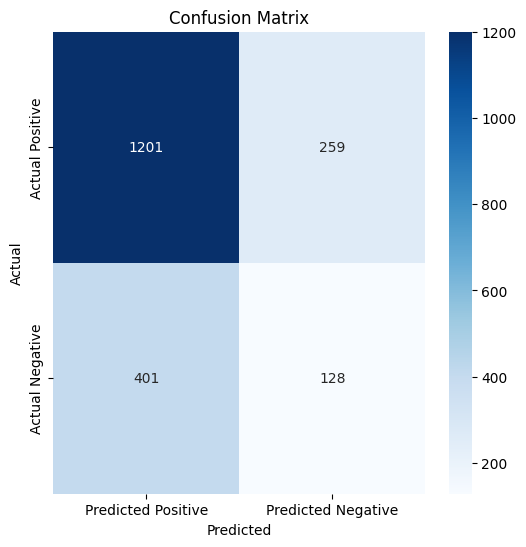

Metrics:
Accuracy: 0.67
F1 Score: 0.78
Precision: 0.82
Recall: 0.75


In [26]:
tp, fp, tn, fn = calculate_metrics_df(result_df)
metrics = plot_metrics_and_confusion_matrix(tp, fp, tn, fn)

print("Metrics:")
print(f"Accuracy: {metrics['Accuracy']:.2f}")
print(f"F1 Score: {metrics['F1 Score']:.2f}")
print(f"Precision: {metrics['Precision']:.2f}")
print(f"Recall: {metrics['Recall']:.2f}")

## Hyperparametertuning using WandB

In [27]:
sweep_config = {
    'method': 'bayes',  
    'metric': {
        'name': 'F1 Score',
        'goal': 'maximize'   
    },
    'parameters': {
        'BG_HISTORY': {'values': [100, 300, 500]},
        'BG_VAR_THRESHOLD': {'values': [16, 32, 48]},
        'DILATE_ITERATIONS': {'values': [1, 2, 3]},
        'ERODE_ITERATIONS': {'values': [1, 2, 3]},
        'BALL_MIN_AREA': {'values': [5, 10, 20]},
        'BALL_MAX_AREA': {'values': [50, 100, 150]},
    }
}

In [28]:
bestF1 = 0
best_config = None

def train(config=None):
    global bestF1
    global best_config
    
    with wandb.init(config=config) as run:
        config = wandb.config
        
        # Set hyperparameters
        global BG_HISTORY, BG_VAR_THRESHOLD, DILATE_ITERATIONS, ERODE_ITERATIONS, BALL_MIN_AREA, BALL_MAX_AREA
        BG_HISTORY = config.BG_HISTORY
        BG_VAR_THRESHOLD = config.BG_VAR_THRESHOLD
        DILATE_ITERATIONS = config.DILATE_ITERATIONS
        ERODE_ITERATIONS = config.ERODE_ITERATIONS
        BALL_MIN_AREA = config.BALL_MIN_AREA
        BALL_MAX_AREA = config.BALL_MAX_AREA

        result_df= pd.DataFrame(columns=['subset', 'video', 'clip', 'frame', 'ball_points', 'player_bbox'])

        # loop over unique combinations
        for i in tqdm(range(len(unique_combinations)), desc="Processing videos"):
            filtered_df = get_frames(df, unique_combinations.iloc[i]['subset'], unique_combinations.iloc[i]['video'], unique_combinations.iloc[i]['clip'])
            filtered_df = process_image_sequence_just_annotations(filtered_df)
            result_df = pd.concat([result_df, filtered_df])

        # calculate tp, fp, tn, fn
        tp, fp, tn, fn = calculate_metrics_df(result_df, loose=False)

        # calculate metrics
        metrics = calculate_agg_metrics(tp, fp, tn, fn)

        #if f1 score is better than previous best, save model
        if metrics['F1 Score'] > bestF1:
            print("New best model found!: F1: " + str(metrics['F1 Score']))
            print("Old F1: " + str(bestF1))
            bestF1 = metrics['F1 Score']

            # Save the best config
            best_config = config

        # log all metrics to wandb
        wandb.log(metrics)

In [ ]:
# run the sweep
#sweep_id = wandb.sweep(sweep_config, project="ball-tracking")
#wandb.agent(sweep_id, train, count=20)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: q1od8byn
Sweep URL: https://wandb.ai/MasterarbeitBV/ball-tracking/sweeps/q1od8byn


wandb: Agent Starting Run: vu9xn80e with config:
wandb: 	BALL_MAX_AREA: 100
wandb: 	BALL_MIN_AREA: 10
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 16
wandb: 	DILATE_ITERATIONS: 1
wandb: 	ERODE_ITERATIONS: 3
wandb: Currently logged in as: spleedy (MasterarbeitBV). Use `wandb login --relogin` to force relogin


Processing videos: 100%|██████████| 42/42 [03:39<00:00,  5.23s/it]


New best model found!: F1: 0.013966956225515244
Old F1: 0


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.05339
F1 Score,0.01397
Precision,0.00949
Recall,0.02641


wandb: Agent Starting Run: k925qtwq with config:
wandb: 	BALL_MAX_AREA: 100
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 500
wandb: 	BG_VAR_THRESHOLD: 16
wandb: 	DILATE_ITERATIONS: 1
wandb: 	ERODE_ITERATIONS: 2


Processing videos: 100%|██████████| 42/42 [03:40<00:00,  5.24s/it]


New best model found!: F1: 0.04193084791613831
Old F1: 0.013966956225515244


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.07342
F1 Score,0.04193
Precision,0.03334
Recall,0.05649


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qk4n0heh with config:
wandb: 	BALL_MAX_AREA: 150
wandb: 	BALL_MIN_AREA: 5
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 2
wandb: 	ERODE_ITERATIONS: 3


Processing videos: 100%|██████████| 42/42 [03:40<00:00,  5.24s/it]


New best model found!: F1: 0.062387128550320144
Old F1: 0.04193084791613831


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.06614
F1 Score,0.06239
Precision,0.03907
Recall,0.15466


wandb: Agent Starting Run: 99ukld5q with config:
wandb: 	BALL_MAX_AREA: 50
wandb: 	BALL_MIN_AREA: 10
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 16
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 1


Processing videos: 100%|██████████| 42/42 [03:46<00:00,  5.39s/it]


New best model found!: F1: 0.15523042015491745
Old F1: 0.062387128550320144


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.11724
F1 Score,0.15523
Precision,0.12937
Recall,0.19402


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bax7telv with config:
wandb: 	BALL_MAX_AREA: 50
wandb: 	BALL_MIN_AREA: 10
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 32
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 2


Processing videos: 100%|██████████| 42/42 [03:44<00:00,  5.33s/it]


New best model found!: F1: 0.2626883135878309
Old F1: 0.15523042015491745


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.1757
F1 Score,0.26269
Precision,0.19281
Recall,0.41202


wandb: Agent Starting Run: bzsqbkgy with config:
wandb: 	BALL_MAX_AREA: 100
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 2


Processing videos: 100%|██████████| 42/42 [03:45<00:00,  5.37s/it]


New best model found!: F1: 0.28956083513318936
Old F1: 0.2626883135878309


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.1932
F1 Score,0.28956
Precision,0.21533
Recall,0.44188


wandb: Agent Starting Run: 5uflncog with config:
wandb: 	BALL_MAX_AREA: 50
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 500
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 3


Processing videos: 100%|██████████| 42/42 [03:44<00:00,  5.35s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.13253
F1 Score,0.16378
Precision,0.1743
Recall,0.15445


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xdh8xiei with config:
wandb: 	BALL_MAX_AREA: 100
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 2


Processing videos: 100%|██████████| 42/42 [03:47<00:00,  5.43s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.1932
F1 Score,0.28956
Precision,0.21533
Recall,0.44188


wandb: Agent Starting Run: x35m85v1 with config:
wandb: 	BALL_MAX_AREA: 100
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 2


Processing videos: 100%|██████████| 42/42 [03:44<00:00,  5.34s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.1932
F1 Score,0.28956
Precision,0.21533
Recall,0.44188


wandb: Agent Starting Run: 4io9lyzg with config:
wandb: 	BALL_MAX_AREA: 50
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 100
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 3


Processing videos: 100%|██████████| 42/42 [03:44<00:00,  5.36s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.13147
F1 Score,0.15884
Precision,0.16711
Recall,0.15135


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nuafhwco with config:
wandb: 	BALL_MAX_AREA: 150
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 2


Processing videos: 100%|██████████| 42/42 [03:49<00:00,  5.48s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.18723
F1 Score,0.28322
Precision,0.20197
Recall,0.47382


wandb: Agent Starting Run: wi59ehtp with config:
wandb: 	BALL_MAX_AREA: 150
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 2


Processing videos: 100%|██████████| 42/42 [03:50<00:00,  5.48s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.18723
F1 Score,0.28322
Precision,0.20197
Recall,0.47382


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wufoncz8 with config:
wandb: 	BALL_MAX_AREA: 150
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 1


Processing videos: 100%|██████████| 42/42 [03:52<00:00,  5.54s/it]


New best model found!: F1: 0.3139839818555532
Old F1: 0.28956083513318936


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.20865
F1 Score,0.31398
Precision,0.21907
Recall,0.55403


wandb: Agent Starting Run: vye6pcfs with config:
wandb: 	BALL_MAX_AREA: 100
wandb: 	BALL_MIN_AREA: 10
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 1


Processing videos: 100%|██████████| 42/42 [03:51<00:00,  5.52s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.173
F1 Score,0.26442
Precision,0.18025
Recall,0.49604


wandb: Agent Starting Run: jaknw9po with config:
wandb: 	BALL_MAX_AREA: 150
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 1


Processing videos: 100%|██████████| 42/42 [03:54<00:00,  5.59s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.20865
F1 Score,0.31398
Precision,0.21907
Recall,0.55403


wandb: Agent Starting Run: i88mk47v with config:
wandb: 	BALL_MAX_AREA: 100
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 100
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 1


Processing videos: 100%|██████████| 42/42 [03:45<00:00,  5.37s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.19402
F1 Score,0.29079
Precision,0.21103
Recall,0.4675


wandb: Agent Starting Run: x6l9l0xe with config:
wandb: 	BALL_MAX_AREA: 150
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 100
wandb: 	BG_VAR_THRESHOLD: 32
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 1


Processing videos: 100%|██████████| 42/42 [03:39<00:00,  5.23s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.20824
F1 Score,0.3128
Precision,0.21865
Recall,0.54935


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ccd2dg7e with config:
wandb: 	BALL_MAX_AREA: 150
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 1


Processing videos: 100%|██████████| 42/42 [03:48<00:00,  5.43s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.20865
F1 Score,0.31398
Precision,0.21907
Recall,0.55403


wandb: Agent Starting Run: je56kgt2 with config:
wandb: 	BALL_MAX_AREA: 150
wandb: 	BALL_MIN_AREA: 10
wandb: 	BG_HISTORY: 100
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 1


Processing videos: 100%|██████████| 42/42 [03:44<00:00,  5.35s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.16687
F1 Score,0.25869
Precision,0.16783
Recall,0.56409


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ja80639x with config:
wandb: 	BALL_MAX_AREA: 150
wandb: 	BALL_MIN_AREA: 20
wandb: 	BG_HISTORY: 300
wandb: 	BG_VAR_THRESHOLD: 48
wandb: 	DILATE_ITERATIONS: 3
wandb: 	ERODE_ITERATIONS: 1


Processing videos: 100%|██████████| 42/42 [03:44<00:00,  5.35s/it]


Accuracy,▁
F1 Score,▁
Precision,▁
Recall,▁
Accuracy,0.20865
F1 Score,0.31398
Precision,0.21907
Recall,0.55403


## Test best Hyperparameters

In [29]:
# apply config to global vars
BG_HISTORY = 300
BG_VAR_THRESHOLD = 48
DILATE_ITERATIONS = 3
ERODE_ITERATIONS = 1
BALL_MIN_AREA = 20
BALL_MAX_AREA = 150

In [35]:
# def caluclate metrics 
def calculate_metrics_df(df, loose=True):
    """Calculate the True Positives, False Positives, True Negatives, and False Negatives for each frame."""
    metrics_dict = {'Dataset_New': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Dataset_TrackNet': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Visibility_Visible': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Visibility_Difficult': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Visibility_Blurry': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Visibility_Occluded': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Visibility_None': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Total': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}}

    for index, row in df.iterrows():
        gt_balls = row['points']
        pred_balls = row['ball_points']
        if loose:
            tp_frame, fp_frame, tn_frame, fn_frame = calculate_metrics_loose(gt_balls, pred_balls) 
        else:
            tp_frame, fp_frame, tn_frame, fn_frame = calculate_metrics_strict(gt_balls, pred_balls)

        dataset="Dataset_"+row['subset']
        visibility = "Visibility_" + (row['points'][0]['visibility'] if  len(row['points']) > 0 else 'None')

        metrics_dict[dataset]['tp'] += tp_frame   
        metrics_dict[dataset]['fp'] += fp_frame
        metrics_dict[dataset]['tn'] += tn_frame
        metrics_dict[dataset]['fn'] += fn_frame

        metrics_dict[visibility]['tp'] += tp_frame
        metrics_dict[visibility]['fp'] += fp_frame
        metrics_dict[visibility]['tn'] += tn_frame
        metrics_dict[visibility]['fn'] += fn_frame

        metrics_dict['Total']['tp'] += tp_frame
        metrics_dict['Total']['fp'] += fp_frame
        metrics_dict['Total']['tn'] += tn_frame
        metrics_dict['Total']['fn'] += fn_frame

    return metrics_dict


# calculate tp, fp, tn, fn
def calculate_metrics_strict(gt_balls, pred_balls, prev_position = None, distance_threshold=10):
    """Calculate the True Positives, False Positives, True Negatives, and False Negatives."""

    if len(gt_balls) == 0 and len(pred_balls) == 0:
        return 0, 0, 1, 0, None
    
    if len(gt_balls) == 0 and len(pred_balls) > 0:
        return 0, 1, 0, 0, pred_balls[0]
    
    if len(gt_balls) > 0 and len(pred_balls) == 0:
        return 0, 0, 0, 1, None
        
    pred_ball= None
    # if more than one preditcion get the closest one to prefious position
    if len(pred_balls) > 1 and prev_position is not None:
        distances = []
        for pred_ball in pred_balls:
            distance = np.linalg.norm(np.array(prev_position) - np.array(pred_ball))
            distances.append(distance)
        pred_ball = pred_balls[np.argmin(distances)]
    else:
        pred_ball = pred_balls[0]

    # get the first ball in the list
    gt_ball = (gt_balls[0]['x'], gt_balls[0]['y'])
    pred_ball = pred_balls[0]

    #calculate euclidean distance
    distance = np.linalg.norm(np.array(gt_ball) - np.array(pred_ball))

    if distance < distance_threshold:
        return 1, 0, 0, 0, pred_ball
    else:
        return 0, 1, 0, 0, pred_ball

# calculate tp, fp, tn, fn
def calculate_metrics_loose(gt_balls, pred_balls, distance_threshold=5):
    """Calculate the True Positives, False Positives, True Negatives, and False Negatives."""

    if len(gt_balls) == 0 and len(pred_balls) == 0:
        return 0, 0, 1, 0
    
    if len(gt_balls) == 0 and len(pred_balls) > 0:
        return 0, 1, 0, 0
    
    if len(gt_balls) > 0 and len(pred_balls) == 0:
        return 0, 0, 0, 1
    
    # if pred balls contains all gt balls tp
    for gt_ball in gt_balls:
        for pred_ball in pred_balls:
            # get the first ball in the list
            gt_ball = (gt_balls[0]['x'], gt_balls[0]['y'])
            pred_ball = pred_balls[0]
            
            #calculate euclidean distance
            distance = np.linalg.norm(np.array(gt_ball) - np.array(pred_ball))

            if distance < distance_threshold:
                return 1, 0, 0, 0
            
    return 0, 0, 0 ,0

In [31]:
result_df= pd.DataFrame(columns=['subset', 'video', 'clip', 'frame', 'ball_points', 'player_bbox'])

# loop over unique combinations
for i in tqdm(range(len(unique_combinations)), desc="Processing videos"):
    filtered_df = get_frames(df, unique_combinations.iloc[i]['subset'], unique_combinations.iloc[i]['video'], unique_combinations.iloc[i]['clip'])
    filtered_df = process_image_sequence_just_annotations(filtered_df)
    result_df = pd.concat([result_df, filtered_df])

Processing videos: 100%|██████████| 13/13 [00:52<00:00,  4.02s/it]


In [36]:
def calculate_positioning_error(gt_balls, pred_balls, prev_position = None):
    """Calculate the True Positives, False Positives, True Negatives, and False Negatives."""

    if len(gt_balls) == 0 and len(pred_balls) == 0:
        return 0, None
    
    if len(gt_balls) == 0 and len(pred_balls) > 0:
        return -1 , pred_balls[0]
    
    if len(gt_balls) > 0 and len(pred_balls) == 0:
        return -1 , None
        
    pred_ball= None
    # if more than one preditcion get the closest one to prefious position
    if len(pred_balls) > 1 and prev_position is not None:
        distances = []
        for pred_ball in pred_balls:
            distance = np.linalg.norm(np.array(prev_position) - np.array(pred_ball))
            distances.append(distance)
        pred_ball = pred_balls[np.argmin(distances)]
    else:
        pred_ball = pred_balls[0]

    # get the first ball in the list
    gt_ball = (gt_balls[0]['x'], gt_balls[0]['y'])
    pred_ball = pred_balls[0]

    #calculate euclidean distance
    distance = np.linalg.norm(np.array(gt_ball) - np.array(pred_ball))

    return distance, pred_ball

def calculate_positioning_error_df(df):
    """Calculate the True Positives, False Positives, True Negatives, and False Negatives for each frame."""
    errors = []
    prev_position = None
    for index, row in df.iterrows():
        gt_balls = row['points']
        pred_balls = row['ball_points']
        error, prev_position = calculate_positioning_error(gt_balls, pred_balls, prev_position)
        errors.append(error)

    # remove -1
    errors = [x for x in errors if x != -1]

    # scale down with factor 2.5
    errors = [x/2.5 for x in errors]

    # count bins for 0, 1,2,3,4,5 >5
    bins = [0, 1, 2, 3, 4, 5, 10000]

    # create counts for bins
    counts = np.bincount(np.digitize(errors, bins))

    # median
    median = np.median(errors)

    # median below th
    filtered_errors = [x for x in errors if x < 4]
    median_below_4 = np.median(filtered_errors)

    return counts, median, median_below_4

In [50]:
# def caluclate metrics 
def calculate_metrics_df(df, loose=True):
    metrics_dict = {'Dataset_Amateur': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Dataset_TrackNet': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Visibility_Visible': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Visibility_Difficult': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Visibility_Blurry': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Visibility_Occluded': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Visibility_None': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
                    'Total': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}}
    
    previous_position = None

    for index, row in df.iterrows():
        gt_balls = row['points']
        pred_balls = row['ball_points']
        if loose:
            tp_frame, fp_frame, tn_frame, fn_frame = calculate_metrics_loose(gt_balls, pred_balls) 
        else:
            tp_frame, fp_frame, tn_frame, fn_frame, previous_position = calculate_metrics_strict(gt_balls, pred_balls, previous_position)

        dataset="Dataset_"+row['subset']
        visibility = "Visibility_" + (row['points'][0]['visibility'] if  len(row['points']) > 0 else 'None')

        metrics_dict[dataset]['tp'] += tp_frame   
        metrics_dict[dataset]['fp'] += fp_frame
        metrics_dict[dataset]['tn'] += tn_frame
        metrics_dict[dataset]['fn'] += fn_frame

        metrics_dict[visibility]['tp'] += tp_frame
        metrics_dict[visibility]['fp'] += fp_frame
        metrics_dict[visibility]['tn'] += tn_frame
        metrics_dict[visibility]['fn'] += fn_frame

        metrics_dict['Total']['tp'] += tp_frame
        metrics_dict['Total']['fp'] += fp_frame
        metrics_dict['Total']['tn'] += tn_frame
        metrics_dict['Total']['fn'] += fn_frame

    return metrics_dict


# calculate tp, fp, tn, fn
def calculate_metrics_strict(gt_balls, pred_balls, prev_position = None, distance_threshold=10):
    if len(gt_balls) == 0 and len(pred_balls) == 0:
        return 0, 0, 1, 0, None
    
    if len(gt_balls) == 0 and len(pred_balls) > 0:
        return 0, 1, 0, 0, pred_balls[0]
    
    if len(gt_balls) > 0 and len(pred_balls) == 0:
        return 0, 0, 0, 1, None
        
    pred_ball= None
    # if more than one preditcion get the closest one to prefious position
    if len(pred_balls) > 1 and prev_position is not None:
        distances = []
        for pred_ball in pred_balls:
            distance = np.linalg.norm(np.array(prev_position) - np.array(pred_ball))
            distances.append(distance)
        pred_ball = pred_balls[np.argmin(distances)]
    else:
        pred_ball = pred_balls[0]

    # get the first ball in the list
    gt_ball = (gt_balls[0]['x'], gt_balls[0]['y'])
    pred_ball = pred_balls[0]

    #calculate euclidean distance
    distance = np.linalg.norm(np.array(gt_ball) - np.array(pred_ball))

    if distance < distance_threshold:
        return 1, 0, 0, 0, pred_ball
    else:
        return 0, 1, 0, 0, pred_ball

In [51]:
metrics = calculate_metrics_df(result_df)
metrics

{'Dataset_Amateur': {'tp': 390, 'fp': 192, 'tn': 134, 'fn': 324},
 'Dataset_TrackNet': {'tp': 345, 'fp': 46, 'tn': 15, 'fn': 62},
 'Visibility_Visible': {'tp': 669, 'fp': 0, 'tn': 0, 'fn': 248},
 'Visibility_Difficult': {'tp': 51, 'fp': 0, 'tn': 0, 'fn': 123},
 'Visibility_Blurry': {'tp': 14, 'fp': 0, 'tn': 0, 'fn': 5},
 'Visibility_Occluded': {'tp': 1, 'fp': 0, 'tn': 0, 'fn': 10},
 'Visibility_None': {'tp': 0, 'fp': 238, 'tn': 149, 'fn': 0},
 'Total': {'tp': 735, 'fp': 238, 'tn': 149, 'fn': 386}}

In [52]:
df_train = convert_json_to_df(data_test, split='train')
df_validation = convert_json_to_df(data_test, split='validation')
df_test = convert_json_to_df(data_test, split='validation')

In [53]:
elements = []

# aggregate for each key
for key, value in metrics.items():
    tp = value['tp']
    fp = value['fp']
    tn = value['tn']
    fn = value['fn']
    metrics_key = calculate_agg_metrics(tp, fp, tn, fn)

    row = {'model': 'Baseline', 'key': key, 'accuracy': metrics_key['Accuracy'], 'f1': metrics_key['F1 Score'], 'precision': metrics_key['Precision'], 'recall': metrics_key['Recall']}
    elements.append(row)

results = pd.DataFrame(elements)
results

,model,key,accuracy,f1,precision,recall
0,Baseline,Dataset_Amateur,0.503846,0.601852,0.670103,0.546218
1,Baseline,Dataset_TrackNet,0.769231,0.864662,0.882353,0.847666
2,Baseline,Visibility_Visible,0.729553,0.843632,1.000000,0.729553
3,Baseline,Visibility_Difficult,0.293103,0.453333,1.000000,0.293103
4,Baseline,Visibility_Blurry,0.736842,0.848485,1.000000,0.736842
5,Baseline,Visibility_Occluded,0.090909,0.166667,1.000000,0.090909
6,Baseline,Visibility_None,0.385013,0.000000,0.000000,0.000000
7,Baseline,Total,0.586207,0.702006,0.755396,0.655665


In [54]:
result_df.head()

,subset,video,clip,frame,ball_points,player_bbox,file_path,points
0,Amateur,Video_1,clip_6,53,[],[],../../00_Dataset/Amateur/Video_1/clip_6/53.jpg,"[{'x': 366, 'y': 552, 'visibility': 'Visible'}]"
1,Amateur,Video_1,clip_6,54,[],[],../../00_Dataset/Amateur/Video_1/clip_6/54.jpg,"[{'x': 366, 'y': 548, 'visibility': 'Visible'}]"
2,Amateur,Video_1,clip_6,55,[],[],../../00_Dataset/Amateur/Video_1/clip_6/55.jpg,"[{'x': 366, 'y': 541, 'visibility': 'Difficult'}]"
3,Amateur,Video_1,clip_6,56,[],[],../../00_Dataset/Amateur/Video_1/clip_6/56.jpg,"[{'x': 368, 'y': 536, 'visibility': 'Difficult'}]"
4,Amateur,Video_1,clip_6,57,[],[],../../00_Dataset/Amateur/Video_1/clip_6/57.jpg,"[{'x': 370, 'y': 536, 'visibility': 'Difficult'}]"


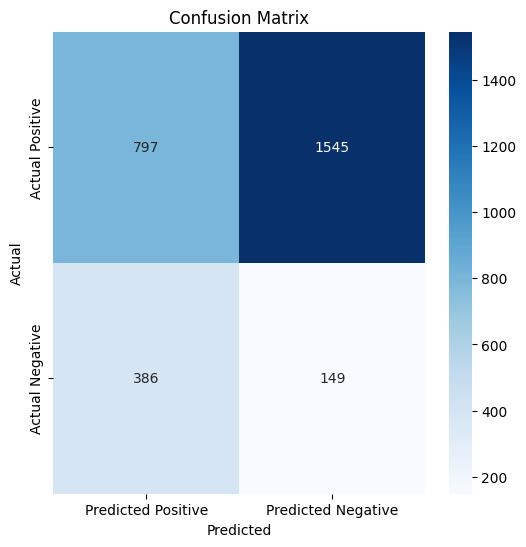

Metrics:
Accuracy: 0.33
F1 Score: 0.45
Precision: 0.34
Recall: 0.67


In [56]:
metrics_dict = calculate_metrics_df(result_df, loose=False)

tp = metrics_dict['Total']['tp']
fp = metrics_dict['Total']['fp']
tn = metrics_dict['Total']['tn']
fn = metrics_dict['Total']['fn']

metrics = plot_metrics_and_confusion_matrix(tp, fp, tn, fn)

print("Metrics:")
print(f"Accuracy: {metrics['Accuracy']:.2f}")
print(f"F1 Score: {metrics['F1 Score']:.2f}")
print(f"Precision: {metrics['Precision']:.2f}")
print(f"Recall: {metrics['Recall']:.2f}")